# COCO object detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.core import *
import json
from collections import defaultdict
import pdb
import pixiedust
import numpy as np

Pixiedust database opened successfully


## Data

In [3]:
coco = untar_data(URLs.COCO_SAMPLE)

In [4]:
img_dir = coco/'train_sample'
annotations = coco/'annotations'/'train_sample.json'

In [5]:
(coco/'annotations').ls()

[PosixPath('/home/gosia/.fastai/data/coco_sample/annotations/train_sample.json')]

In [6]:
img_list = ImageList.from_folder(img_dir)

In [7]:
img_list

ImageList (21837 items)
Image (3, 487, 600),Image (3, 480, 640),Image (3, 500, 375),Image (3, 425, 640),Image (3, 640, 513)
Path: /home/gosia/.fastai/data/coco_sample/train_sample

In [8]:
#image size
sz = 224

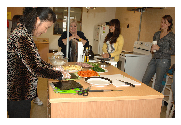

In [9]:
show_image(img_list[3])

In [10]:
with open(annotations) as f:
    train_json = json.load(f)

In [50]:
ncat = len(train_json['categories'])
train_json['categories']

[{'id': 62, 'name': 'chair'},
 {'id': 63, 'name': 'couch'},
 {'id': 72, 'name': 'tv'},
 {'id': 75, 'name': 'remote'},
 {'id': 84, 'name': 'book'},
 {'id': 86, 'name': 'vase'}]

In [51]:
train_json

{'categories': [{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 'annotations': [{'image_id': 318219,
   'bbox': [505.24, 0.0, 47.86, 309.25],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [470.68, 0.0, 45.93, 191.86],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [442.51, 0.0, 43.39, 119.87],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [380.74, 112.85, 40.62, 248.82],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [339.13, 32.99, 32.99, 175.5],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [359.55, 68.79, 46.02, 202.79],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [322.48, 0.0, 47.25, 158.32],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [306.61, 0.33, 28.95, 71.64],
   'category_id': 72},
  {'image_id': 118113,
   'bbox': [284.04, 180.23, 43.78, 14.87],
   'category_id': 84

In [12]:
# count the number of annotations per object
img_ann_counts = defaultdict(lambda: 0)
for ann in train_json['annotations']:
    img_ann_counts[ann['image_id']] += 1

In [13]:
len(img_ann_counts)

21837

In [14]:
images, lbl_bbox = get_annotations(annotations)

In [15]:
lbl_bbox[0], images[0]

([[[0.0, 505.24, 309.25, 553.1],
   [0.0, 470.68, 191.86, 516.61],
   [0.0, 442.51, 119.87, 485.9]],
  ['tv', 'tv', 'tv']],
 '000000318219.jpg')

torch.Size([3, 326, 640])

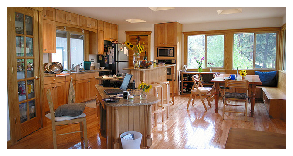

In [16]:
img = open_image(img_dir/images[3])
show_image(img, figsize=(5,5))
img.shape

In [17]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [18]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct(valid_pct=0.1, seed=0)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), size=sz, tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=8, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

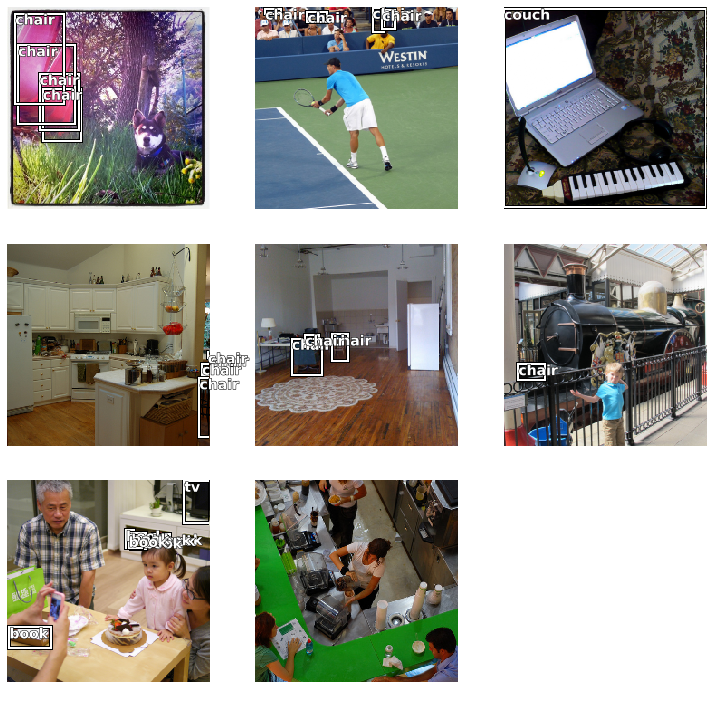

In [19]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(10,10))

In [20]:
data

ImageDataBunch;

Train: LabelList (19654 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/gosia/.fastai/data/coco_sample;

Valid: LabelList (2183 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/gosia/.fastai/data/coco_sample;

Test: None

In [21]:
data.train_ds.y.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

## Model

In [22]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [23]:
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [24]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (ncat+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [25]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [26]:
head_reg4 = SSD_Head(k=1, bias=-3.)
learn = cnn_learner(data, models.resnet34, custom_head=head_reg4)

In [27]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

## Play with the loss function

In [28]:
# get one item from the data and prepare it for putting it through the model
itemno = 1
item = data.valid_ds[itemno][0]
x, y = data.one_item(item)
# get one batch of data (x - img, y - ground truth)
#x, y = data.one_batch(cpu=False)

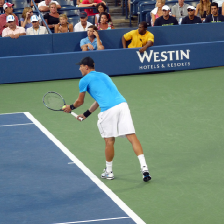

In [29]:
item

In [30]:
# run the item through the model, get bboxes and classes
b_clas, b_bb = learn.model(x)

In [31]:
b_clas.shape, b_bb.shape

(torch.Size([1, 16, 7]), torch.Size([1, 16, 4]))

In [32]:
# get the first (and only) item from the result batch to examine
idx = 0
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]

In [33]:
b_clasi.shape, b_bboxi.shape, b_clasi[0], b_bboxi[0]

(torch.Size([16, 7]),
 torch.Size([16, 4]),
 tensor([ 1.3865, -1.2462,  0.3048,  2.2381, -0.2463,  1.7191, -1.1837],
        device='cuda:0', grad_fn=<SelectBackward>),
 tensor([ 1.4900,  0.6477, -2.0272,  1.9558], device='cuda:0',
        grad_fn=<SelectBackward>))

In [118]:
# get the itemno item from the ground truth
label = data.valid_ds[itemno][1]
bbox, clas = label.data
bbox = bbox.cuda()
clas = torch.tensor(clas).cuda()
bboxi = bbox
clasi = clas

In [119]:
bboxi.shape, clasi.shape, bboxi, clasi

(torch.Size([4, 4]),
 torch.Size([4]),
 tensor([[-0.9910, -0.9073, -0.9416, -0.7544],
         [-0.9997,  0.1552, -0.7628,  0.2663],
         [-0.9600, -0.4887, -0.8562, -0.2979],
         [-0.9791,  0.2508, -0.7892,  0.3821]], device='cuda:0'),
 tensor([2, 2, 2, 2], device='cuda:0'))

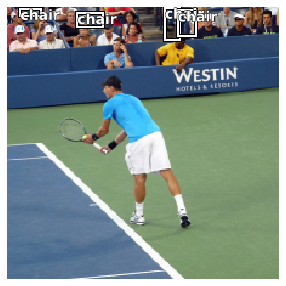

In [120]:
# look at it
item.show(y=label, figsize=(5,5))

### Create anchor boxes

In [121]:
# create a tensor with anchor boxes - middles + sizes
# coordinates of bboxes are scaled to -1,1, so anchor boxes must be too
ncells = 4
k = 1 # num boxes per cell
first_ctr = -1 + 2/(2*ncells)
last_ctr  =  1 - 2/(2*ncells)
a_x = np.repeat(np.linspace(first_ctr, last_ctr, ncells), ncells)
a_y = np.tile(np.linspace(first_ctr, last_ctr, ncells), ncells)
a_sz = np.array([2/ncells for _ in a_x])
anchors = torch.tensor(np.stack([a_x, a_y, a_sz, a_sz], axis=1)).type(torch.FloatTensor).cuda()
anchors

tensor([[-0.7500, -0.7500,  0.5000,  0.5000],
        [-0.7500, -0.2500,  0.5000,  0.5000],
        [-0.7500,  0.2500,  0.5000,  0.5000],
        [-0.7500,  0.7500,  0.5000,  0.5000],
        [-0.2500, -0.7500,  0.5000,  0.5000],
        [-0.2500, -0.2500,  0.5000,  0.5000],
        [-0.2500,  0.2500,  0.5000,  0.5000],
        [-0.2500,  0.7500,  0.5000,  0.5000],
        [ 0.2500, -0.7500,  0.5000,  0.5000],
        [ 0.2500, -0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.7500,  0.5000,  0.5000],
        [ 0.7500, -0.7500,  0.5000,  0.5000],
        [ 0.7500, -0.2500,  0.5000,  0.5000],
        [ 0.7500,  0.2500,  0.5000,  0.5000],
        [ 0.7500,  0.7500,  0.5000,  0.5000]], device='cuda:0')

In [122]:
# centre+height/width -> corners
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [123]:
# create a tensor with anchor corners
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[-1.0000, -1.0000, -0.5000, -0.5000],
        [-1.0000, -0.5000, -0.5000,  0.0000],
        [-1.0000,  0.0000, -0.5000,  0.5000],
        [-1.0000,  0.5000, -0.5000,  1.0000],
        [-0.5000, -1.0000,  0.0000, -0.5000],
        [-0.5000, -0.5000,  0.0000,  0.0000],
        [-0.5000,  0.0000,  0.0000,  0.5000],
        [-0.5000,  0.5000,  0.0000,  1.0000],
        [ 0.0000, -1.0000,  0.5000, -0.5000],
        [ 0.0000, -0.5000,  0.5000,  0.0000],
        [ 0.0000,  0.0000,  0.5000,  0.5000],
        [ 0.0000,  0.5000,  0.5000,  1.0000],
        [ 0.5000, -1.0000,  1.0000, -0.5000],
        [ 0.5000, -0.5000,  1.0000,  0.0000],
        [ 0.5000,  0.0000,  1.0000,  0.5000],
        [ 0.5000,  0.5000,  1.0000,  1.0000]], device='cuda:0')

In [124]:
grid_sizes = torch.tensor(np.array([2/ncells]), requires_grad=False).type(torch.FloatTensor).unsqueeze(1).cuda()
grid_sizes

tensor([[0.5000]], device='cuda:0')

### Jaccard index (intersection over union)

In [125]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

### Testing loss function components

In [126]:
# computer jaccard index for each pair of bbox / anchor box
overlaps = jaccard(bbox.data.cuda(), anchor_cnr)
overlaps

tensor([[0.0302, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1053, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0792, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0998, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [127]:
overlaps.max(1)

torch.return_types.max(
values=tensor([0.0302, 0.1053, 0.0792, 0.0998], device='cuda:0'),
indices=tensor([0, 2, 1, 2], device='cuda:0'))

In [128]:
overlaps.max(0)

torch.return_types.max(
values=tensor([0.0302, 0.0792, 0.1053, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0'),
indices=tensor([0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [129]:
gt_overlap, gt_idx = map_to_ground_truth(overlaps)
gt_overlap, gt_idx

(tensor([1.9900, 1.9900, 1.9900, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        device='cuda:0'),
 tensor([0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [130]:
gt_clas = clas[gt_idx]; gt_clas

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

In [131]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(~pos)[:,0]
pos_idx

tensor([0, 1, 2], device='cuda:0')

In [132]:
a_ic = actn_to_bb(b_bboxi, anchors)
gt_bbox = bbox.cuda()[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

(tensor(0.3683, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(4.7696, device='cuda:0', grad_fn=<NllLossBackward>))

In [135]:
a_ic[pos_idx] - gt_bbox[pos_idx]

tensor([[ 0.3376, -0.0702,  0.5467,  0.5170],
        [ 0.3288,  0.1151,  0.4752,  0.6511],
        [ 0.3478, -0.1258,  0.4124,  0.4924]], device='cuda:0',
       grad_fn=<SubBackward0>)

## Loss

In [160]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = t[:,:-1].contiguous().cuda()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(ncat)

In [161]:
# remove padding - images in a minibatch will have a different number of objects
# those with fewer objects will have their bbox groundtruth tensor padded with 0s
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def ssd_1_loss(b_c,b_bb,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,False)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = ncat
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ_bb,targ_c):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,targ_bb,targ_c):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
        lls += loc_loss
        lcs += clas_loss
#    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

## Train

In [162]:
head_reg4 = SSD_Head(k=1, bias=-3.)
learn = cnn_learner(data, models.resnet34, loss_func=ssd_loss, custom_head=head_reg4)

In [163]:
lr_find(learn)
learn.recorder.plot()

/home/gosia/fastai/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: cannot perform reduction function max on tensor with no elements because the operation does not have an identity

In [164]:
%debug

> <ipython-input-125-9f87ef07a2a2>(15)map_to_ground_truth()
     13 
     14 def map_to_ground_truth(overlaps, print_it=False):
---> 15     prior_overlap, prior_idx = overlaps.max(1)
     16     if print_it: print(prior_overlap)
     17 #     pdb.set_trace()

ipdb> p overlaps
tensor([], device='cuda:0', size=(0, 16))
ipdb> u
> <ipython-input-161-a704c366fb51>(12)ssd_1_loss()
     10     a_ic = actn_to_bb(b_bb, anchors)
     11     overlaps = jaccard(bbox.data, anchor_cnr.data)
---> 12     gt_overlap,gt_idx = map_to_ground_truth(overlaps,False)
     13     gt_clas = clas[gt_idx]
     14     pos = gt_overlap > 0.4

ipdb> p bbox.data
tensor([], device='cuda:0', size=(0, 4))
ipdb> p anchor_cnr.data
tensor([[-1.0000, -1.0000, -0.5000, -0.5000],
        [-1.0000, -0.5000, -0.5000,  0.0000],
        [-1.0000,  0.0000, -0.5000,  0.5000],
        [-1.0000,  0.5000, -0.5000,  1.0000],
        [-0.5000, -1.0000,  0.0000, -0.5000],
        [-0.5000, -0.5000,  0.0000,  0.0000],
        [-0.5000,  0